In [1]:
import pandas as pd 
pd.set_option('display.max_columns', 500)
import numpy as np
from matplotlib import pyplot as plt 
from tqdm import tqdm
from sklearn.metrics import f1_score
import os 
import lightgbm as lgb
import gc
import pickle
from sklearn.model_selection import KFold, StratifiedKFold, TimeSeriesSplit, RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_predict

from scipy.stats import mode

---

In [2]:
data_pth = 'D:/signaling_heroes/datasets/'

model_name = 'train_attacks'
MainPth = 'C:/Users/denis/Machine_Learning_Competitions/anomaly_ericsson/'
ModelFolder = f'{MainPth}{model_name}/'
model_config = {}

---

# Read data 

In [3]:
training_data_attacks = pd.read_csv(f'{data_pth}training_data_attacks.csv')
training_data = pd.read_csv(f'{data_pth}training_data.csv')

print('Shape:', training_data_attacks.shape)
training_data_attacks.head()

C:\Users\denis\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (102,103,112,113) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Shape: (377709, 120)


Unnamed: 0  frame_time_epoch  frame_len  sccp_called_digits  \
0           0      1.518010e+09      212.0        4.910192e+11   
1           1      1.518010e+09      288.0        4.910192e+11   
2           2      1.518010e+09      252.0        4.910192e+11   
3           3      1.518010e+09      352.0        4.910192e+11   
4           4      1.518010e+09      352.0        4.910192e+11   

   sccp_calling_digits  sccp_calling_ssn  sccp_called_ssn  sccp_message_type  \
0         4.910190e+11               6.0              7.0               17.0   
1         4.910190e+11               6.0              8.0               17.0   
2         4.910190e+11               6.0              8.0               17.0   
3         4.910190e+11               6.0              7.0               17.0   
4         4.910190e+11               6.0              7.0               17.0   

       tcap_tid     tcap_dtid  tcap_application_context_name  tcap_localValue  \
0  1.112611e+10  1.112611e+10                     40010182.0             13.0   
1  5.110001e+09  7.077430e+07                      4001053.0             22.0   
2  7.077430e+07  7.077430e+07                            0.0             22.0   
3  0.000000e+00  0.000000e+00                            0.0              0.0   
4  0.000000e+00  0.000000e+00                            0.0              0.0   

   tcap_result  tcap_returnResultLast_element  tcap_invokeID  \
0          0.0                            1.0            0.0   
1          0.0                            0.0            0.0   
2          0.0                            1.0            0.0   
3          0.0                            0.0            0.0   
4          0.0                            0.0            0.0   

   gsm_old_localValue  gsm_old_invokeID  tcap_tid_2     tcap_otid  \
0                13.0               0.0         0.0  0.000000e+00   
1                22.0               0.0  70774303.0  5.110001e+09   
2                22.0               0.0         0.0  0.000000e+00   
3                 0.0               0.0         0.0  0.000000e+00   
4                 0.0               0.0         0.0  0.000000e+00   

      e212_imsi   e164_msisdn  e164_msisdn_2  e212_mcc  e212_mnc  \
0  0.000000e+00  0.000000e+00   0.000000e+00       0.0       0.0   
1  2.621731e+14  4.910193e+10   4.910193e+10     262.0      17.0   
2  0.000000e+00  4.910192e+10   4.910192e+10       0.0       0.0   
3  0.000000e+00  0.000000e+00   0.000000e+00       0.0       0.0   
4  0.000000e+00  0.000000e+00   0.000000e+00       0.0       0.0   

   e164_country_code  e164_country_code_2  gsm_map_ms_gsmSCF_Address  \
0                0.0                  0.0               0.000000e+00   
1               49.0                 49.0               9.194019e+14   
2               49.0                 49.0               0.000000e+00   
3                0.0                  0.0               0.000000e+00   
4                0.0                  0.0               0.000000e+00   

   gsm_map_ms_gsmSCF_Address_2  gsm_map_ms_phase1  gsm_map_ms_phase2  \
0                 0.000000e+00                0.0                0.0   
1                 9.194019e+14                0.0                0.0   
2                 0.000000e+00                1.0                1.0   
3                 0.000000e+00                0.0                0.0   
4                 0.000000e+00                0.0                0.0   

   gsm_map_ms_phase3  gsm_map_ms_phase4  gsm_map_ms_ageOfLocationInformation  \
0                0.0                0.0                                  0.0   
1                0.0                0.0                                  0.0   
2                0.0                0.0                                  5.0   
3                0.0                0.0                                  0.0   
4                0.0                0.0                                  0.0   

   gsm_map_ms_geographicalInformation  \
0                        0.000000e+00   


In [4]:
[x for x in training_data_attacks.columns if 'Number' in x]

['gsm_map_ms_hlr_Number',
 'gsm_map_ms_msc_Number',
 'gsm_map_ms_vlr_Number',
 'gsm_map_ss_forwardedToNumber',
 'gsm_map_ms_sgsn_Number',
 'gsm_map_ss_forwardedToNumber_2',
 'gsm_map_ss_forwardedToNumber_3',
 'gsm_map_ss_forwardedToNumber_4',
 'gsm_map_ss_forwardedToNumber_more']

In [5]:
y_train = training_data_attacks['label']
training_data_attacks = training_data_attacks.drop(['label', 'Unnamed: 0'],axis=1)

In [6]:
training_data_attacks.shape, training_data.shape

((377709, 118), (377709, 118))

In [7]:
training_data = training_data.fillna(0)

In [8]:
for cc in training_data_attacks.columns:
    if cc not in training_data.columns:
        print(cc)

In [9]:
for cc in training_data.columns:
    if cc not in training_data_attacks.columns:
        print(cc)

In [10]:
for cc in training_data.columns[training_data.dtypes=='O']:
    training_data = training_data.drop(cc,axis=1)
    training_data_attacks = training_data_attacks.drop(cc,axis=1)
    
training_data = training_data.astype('float64')

In [11]:
df = training_data_attacks-training_data
df.columns = [f'diff_{x}' for x in training_data_attacks.columns]

In [12]:
#training_data_attacks = pd.concat([training_data_attacks, df],axis=1)

In [13]:
np.sum(df, axis=1)

0        -2.384186e-07
1        -2.384186e-07
2        -2.384186e-07
3         2.384186e-07
4         2.384186e-07
5         2.384186e-07
6         2.384186e-07
7         2.384186e-07
8         2.384186e-07
9         0.000000e+00
10        0.000000e+00
11        0.000000e+00
12        0.000000e+00
13        0.000000e+00
14        0.000000e+00
15        0.000000e+00
16        0.000000e+00
17        0.000000e+00
18        2.384186e-07
19        2.384186e-07
20        0.000000e+00
21        0.000000e+00
22        0.000000e+00
23        2.384186e-07
24        2.384186e-07
25        2.384186e-07
26        0.000000e+00
27        0.000000e+00
28        0.000000e+00
29        0.000000e+00
              ...     
377679    0.000000e+00
377680    0.000000e+00
377681    0.000000e+00
377682    0.000000e+00
377683    0.000000e+00
377684    2.384186e-07
377685    2.384186e-07
377686    2.384186e-07
377687    0.000000e+00
377688    0.000000e+00
377689    0.000000e+00
377690    0.000000e+00
377691    0

In [14]:
df.head(11)

diff_frame_time_epoch  diff_frame_len  diff_sccp_called_digits  \
0           -2.384186e-07             0.0                      0.0   
1           -2.384186e-07             0.0                      0.0   
2           -2.384186e-07             0.0                      0.0   
3            2.384186e-07             0.0                      0.0   
4            2.384186e-07             0.0                      0.0   
5            2.384186e-07             0.0                      0.0   
6            2.384186e-07             0.0                      0.0   
7            2.384186e-07             0.0                      0.0   
8            2.384186e-07             0.0                      0.0   
9            0.000000e+00             0.0                      0.0   
10           0.000000e+00             0.0                      0.0   

    diff_sccp_calling_digits  diff_sccp_calling_ssn  diff_sccp_called_ssn  \
0                        0.0                    0.0                   0.0   
1                        0.0                    0.0                   0.0   
2                        0.0                    0.0                   0.0   
3                        0.0                    0.0                   0.0   
4                        0.0                    0.0                   0.0   
5                        0.0                    0.0                   0.0   
6                        0.0                    0.0                   0.0   
7                        0.0                    0.0                   0.0   
8                        0.0                    0.0                   0.0   
9                        0.0                    0.0                   0.0   
10                       0.0                    0.0                   0.0   

    diff_sccp_message_type  diff_tcap_tid  diff_tcap_dtid  \
0                      0.0            0.0             0.0   
1                      0.0            0.0             0.0   
2                      0.0            0.0             0.0   
3                      0.0            0.0             0.0   
4                      0.0            0.0             0.0   
5                      0.0            0.0             0.0   
6                      0.0            0.0             0.0   
7                      0.0            0.0             0.0   
8                      0.0            0.0             0.0   
9                      0.0            0.0             0.0   
10                     0.0            0.0             0.0   

    diff_tcap_application_context_name  diff_tcap_localValue  \
0                                  0.0                   0.0   
1                                  0.0                   0.0   
2                                  0.0                   0.0   
3                                  0.0                   0.0   
4                                  0.0                   0.0   
5                                  0.0                   0.0   
6                                  0.0                   0.0   
7                                  0.0                   0.0   
8                                  0.0                   0.0   
9                                  0.0                   0.0   
10                                 0.0                   0.0   

    diff_tcap_result  diff_tcap_returnResultLast_element  diff_tcap_invokeID  \
0                0.0                                 0.0                 0.0   
1                0.0                                 0.0                 0.0   
2                0.0                                 0.0                 0.0   
3                0.0                                 0.0                 0.0   
4                0.0                                 0.0                 0.0   
5                0.0                                 0.0                 0.0   
6                0.0                                 0.0                 0.0   
7                0.0                                 0.0                 0.0   
8               

# X_train / X_test

In [15]:
X_train = training_data_attacks #.drop(['label', 'Unnamed: 0'],axis=1)
#y_train = training_data_attacks['label']
y_train = y_train.astype('int')

In [16]:
X_train.shape

(377709, 111)

### Drop all featues with 'object' type

In [17]:
X_train.columns[X_train.dtypes=='O']
for cc in X_train.columns[X_train.dtypes=='O']:
    X_train = X_train.drop(cc, axis=1)

In [18]:
model_config['Xtrain_columns'] = list(X_train.columns)

# Model 

In [19]:
def scoring(y_true, y_hat):
    return roc_auc_score(y_true, y_hat)

loss_function_name = 'auc'
kf = KFold(n_splits=10, random_state=2018, shuffle=False)

In [20]:
params = {
    'objective':'binary', 
    'learning_rate': 0.01, 
    'random_state': 2018,
    'verbose_eval': 0,
    'class_weight': 'balanced',
    'max_depth':-1
}

In [21]:
def determine_opt_th(y_true, y_hat_probs, verbose=True):
    thresholds = []
    scores = []
    for th in [0.001, 0.005, 0.01, 0.1, 0.2]:  #list(set(y_hat_probs)):
        # th = np.exp(p)
        y_hat_bin = (y_hat_probs >= th) * 1
    
        thresholds.append(th)
        scores.append(f1_score(y_true, y_hat_bin))
        
    
    ind_best_score = np.argmax(scores)
    best_score = scores[ind_best_score]
    best_th = thresholds[ind_best_score]
    
    if verbose:
        print('Best score:', best_score)
        print('Best threshold:', best_th)
    
    return best_score, best_th

In [33]:
scores = []
opt_ths = []

for n_fold, (train_index, test_index) in tqdm(enumerate(kf.split(X_train, y_train))):
    
    # replace cat cols 
    X_train_temp = X_train.iloc[train_index].reset_index(drop=True).copy()
    X_val_temp = X_train.iloc[test_index].reset_index(drop=True).copy()
    y_train_temp = y_train[train_index]
    y_val_temp = y_train[test_index]
    
    lgb_data_train = lgb.Dataset(X_train_temp, 
                                 label=y_train_temp,
                                 free_raw_data=False)

    lgb_data_valid = lgb.Dataset(X_val_temp, 
                                 label=y_val_temp,
                                 free_raw_data=False,
                                 reference=lgb_data_train)
    model = lgb.train(params, 
                      lgb_data_train, 
                      valid_sets = [lgb_data_train, lgb_data_valid],
                      verbose_eval=10,
                      early_stopping_rounds=50,
                      num_boost_round=500)
    
    y_hat_probs = np.array(model.predict(X_val_temp))
    y_true = np.array(y_train[test_index])
    
    ind_val, ind_test, _, _ = train_test_split(np.arange(len(y_true)), np.arange(len(y_true)), test_size=0.5, random_state=42,
                                              stratify = y_true)
    
    score, th = determine_opt_th(y_true[ind_val], y_hat_probs[ind_val])
    
    print('Score for test:')
    test_score = f1_score(y_true[ind_test], y_hat_probs[ind_test]>th)
    print(test_score)
    print('Anomalies in validation/test:', np.sum(y_true[ind_val]), np.sum(y_true[ind_test]))
    
    scores.append(test_score)
    opt_ths.append(th)

0it [00:00, ?it/s]

Training until validation scores don't improve for 50 rounds.
[10]	training's binary_logloss: 0.000718667	valid_1's binary_logloss: 0.000718515
[20]	training's binary_logloss: 0.000650254	valid_1's binary_logloss: 0.000650117
[30]	training's binary_logloss: 0.000588355	valid_1's binary_logloss: 0.000588231
[40]	training's binary_logloss: 0.000532351	valid_1's binary_logloss: 0.000532239
[50]	training's binary_logloss: 0.000481678	valid_1's binary_logloss: 0.000481577
[60]	training's binary_logloss: 0.00043583	valid_1's binary_logloss: 0.000435739
[70]	training's binary_logloss: 0.000394347	valid_1's binary_logloss: 0.000394264
[80]	training's binary_logloss: 0.000356813	valid_1's binary_logloss: 0.000356738
[90]	training's binary_logloss: 0.000322852	valid_1's binary_logloss: 0.000322784
[100]	training's binary_logloss: 0.000292124	valid_1's binary_logloss: 0.000292063
[110]	training's binary_logloss: 0.000264321	valid_1's binary_logloss: 0.000264266
[120]	training's binary_logloss: 0.

1it [00:28, 28.67s/it]

Training until validation scores don't improve for 50 rounds.
[10]	training's binary_logloss: 0.000712147	valid_1's binary_logloss: 0.000786424
[20]	training's binary_logloss: 0.000638409	valid_1's binary_logloss: 0.000705504
[30]	training's binary_logloss: 0.000575001	valid_1's binary_logloss: 0.000646906
[40]	training's binary_logloss: 0.000518906	valid_1's binary_logloss: 0.000593049
[50]	training's binary_logloss: 0.000468702	valid_1's binary_logloss: 0.000544256
[60]	training's binary_logloss: 0.000423568	valid_1's binary_logloss: 0.000497337
[70]	training's binary_logloss: 0.000382903	valid_1's binary_logloss: 0.000452106
[80]	training's binary_logloss: 0.000346216	valid_1's binary_logloss: 0.000411304
[90]	training's binary_logloss: 0.000313094	valid_1's binary_logloss: 0.000374409
[100]	training's binary_logloss: 0.000283174	valid_1's binary_logloss: 0.00034099
[110]	training's binary_logloss: 0.000256138	valid_1's binary_logloss: 0.000310677
[120]	training's binary_logloss: 0.

2it [00:48, 25.98s/it]

Training until validation scores don't improve for 50 rounds.
[10]	training's binary_logloss: 0.000771729	valid_1's binary_logloss: 0.000816029
[20]	training's binary_logloss: 0.000684698	valid_1's binary_logloss: 0.000743966
[30]	training's binary_logloss: 0.000613434	valid_1's binary_logloss: 0.000670511
[40]	training's binary_logloss: 0.00055145	valid_1's binary_logloss: 0.0006066
[50]	training's binary_logloss: 0.000496727	valid_1's binary_logloss: 0.000549884
[60]	training's binary_logloss: 0.000447977	valid_1's binary_logloss: 0.000499099
[70]	training's binary_logloss: 0.00040426	valid_1's binary_logloss: 0.000453349
[80]	training's binary_logloss: 0.000365002	valid_1's binary_logloss: 0.000412221
[90]	training's binary_logloss: 0.000329688	valid_1's binary_logloss: 0.000375008
[100]	training's binary_logloss: 0.000297886	valid_1's binary_logloss: 0.00034129
[110]	training's binary_logloss: 0.000269217	valid_1's binary_logloss: 0.000310706
[120]	training's binary_logloss: 0.0002

3it [01:01, 22.24s/it]

Training until validation scores don't improve for 50 rounds.
[10]	training's binary_logloss: 0.00072783	valid_1's binary_logloss: 0.00070161
[20]	training's binary_logloss: 0.000654463	valid_1's binary_logloss: 0.000634832
[30]	training's binary_logloss: 0.000589827	valid_1's binary_logloss: 0.00057443
[40]	training's binary_logloss: 0.000532361	valid_1's binary_logloss: 0.000519753
[50]	training's binary_logloss: 0.000480858	valid_1's binary_logloss: 0.000470267
[60]	training's binary_logloss: 0.000434544	valid_1's binary_logloss: 0.000425497
[70]	training's binary_logloss: 0.000392815	valid_1's binary_logloss: 0.000384992
[80]	training's binary_logloss: 0.000355169	valid_1's binary_logloss: 0.000348346
[90]	training's binary_logloss: 0.000321152	valid_1's binary_logloss: 0.000315196
[100]	training's binary_logloss: 0.00029043	valid_1's binary_logloss: 0.000285202
[110]	training's binary_logloss: 0.000262672	valid_1's binary_logloss: 0.000258064
[120]	training's binary_logloss: 0.000

4it [01:27, 23.39s/it]

Training until validation scores don't improve for 50 rounds.
[10]	training's binary_logloss: 0.000752609	valid_1's binary_logloss: 0.000725589
[20]	training's binary_logloss: 0.0006776	valid_1's binary_logloss: 0.000656535
[30]	training's binary_logloss: 0.000610995	valid_1's binary_logloss: 0.000594081
[40]	training's binary_logloss: 0.000551559	valid_1's binary_logloss: 0.000537592
[50]	training's binary_logloss: 0.000498281	valid_1's binary_logloss: 0.000486495
[60]	training's binary_logloss: 0.000450305	valid_1's binary_logloss: 0.000440239
[70]	training's binary_logloss: 0.000407025	valid_1's binary_logloss: 0.000398355
[80]	training's binary_logloss: 0.000367987	valid_1's binary_logloss: 0.000360461
[90]	training's binary_logloss: 0.000332747	valid_1's binary_logloss: 0.000326174
[100]	training's binary_logloss: 0.00030092	valid_1's binary_logloss: 0.000295151
[110]	training's binary_logloss: 0.000272165	valid_1's binary_logloss: 0.00026708
[120]	training's binary_logloss: 0.000

5it [01:54, 24.34s/it]

Training until validation scores don't improve for 50 rounds.
[10]	training's binary_logloss: 0.00074882	valid_1's binary_logloss: 0.000721268
[20]	training's binary_logloss: 0.000674344	valid_1's binary_logloss: 0.000652652
[30]	training's binary_logloss: 0.00060816	valid_1's binary_logloss: 0.000590525
[40]	training's binary_logloss: 0.000549138	valid_1's binary_logloss: 0.000534314
[50]	training's binary_logloss: 0.000496122	valid_1's binary_logloss: 0.000483472
[60]	training's binary_logloss: 0.000448338	valid_1's binary_logloss: 0.000437499
[70]	training's binary_logloss: 0.000405272	valid_1's binary_logloss: 0.000395909
[80]	training's binary_logloss: 0.000366417	valid_1's binary_logloss: 0.000358283
[90]	training's binary_logloss: 0.000331337	valid_1's binary_logloss: 0.000324245
[100]	training's binary_logloss: 0.00029965	valid_1's binary_logloss: 0.000293453
[110]	training's binary_logloss: 0.000271019	valid_1's binary_logloss: 0.000265599
[120]	training's binary_logloss: 0.00

6it [02:21, 25.10s/it]

Training until validation scores don't improve for 50 rounds.
[10]	training's binary_logloss: 0.000754259	valid_1's binary_logloss: 0.00072663
[20]	training's binary_logloss: 0.000679139	valid_1's binary_logloss: 0.000657466
[30]	training's binary_logloss: 0.000612625	valid_1's binary_logloss: 0.000594881
[40]	training's binary_logloss: 0.000553253	valid_1's binary_logloss: 0.000538255
[50]	training's binary_logloss: 0.000499855	valid_1's binary_logloss: 0.000487038
[60]	training's binary_logloss: 0.000451736	valid_1's binary_logloss: 0.000440706
[70]	training's binary_logloss: 0.000408363	valid_1's binary_logloss: 0.000398782
[80]	training's binary_logloss: 0.000369228	valid_1's binary_logloss: 0.000360856
[90]	training's binary_logloss: 0.000333893	valid_1's binary_logloss: 0.000326537
[100]	training's binary_logloss: 0.000301975	valid_1's binary_logloss: 0.000295477
[110]	training's binary_logloss: 0.000273133	valid_1's binary_logloss: 0.000267363
[120]	training's binary_logloss: 0.

7it [02:47, 25.45s/it]

Training until validation scores don't improve for 50 rounds.
[10]	training's binary_logloss: 0.00073273	valid_1's binary_logloss: 0.000731962
[20]	training's binary_logloss: 0.000662977	valid_1's binary_logloss: 0.000662283
[30]	training's binary_logloss: 0.000599867	valid_1's binary_logloss: 0.000599239
[40]	training's binary_logloss: 0.000542766	valid_1's binary_logloss: 0.000542198
[50]	training's binary_logloss: 0.000491102	valid_1's binary_logloss: 0.000490588
[60]	training's binary_logloss: 0.000444357	valid_1's binary_logloss: 0.000443892
[70]	training's binary_logloss: 0.000402062	valid_1's binary_logloss: 0.000401641
[80]	training's binary_logloss: 0.000363793	valid_1's binary_logloss: 0.000363413
[90]	training's binary_logloss: 0.000329168	valid_1's binary_logloss: 0.000328824
[100]	training's binary_logloss: 0.000297839	valid_1's binary_logloss: 0.000297527
[110]	training's binary_logloss: 0.000269492	valid_1's binary_logloss: 0.00026921
[120]	training's binary_logloss: 0.0

8it [03:12, 25.36s/it]

Training until validation scores don't improve for 50 rounds.
[10]	training's binary_logloss: 0.000760791	valid_1's binary_logloss: 0.000801985
[20]	training's binary_logloss: 0.000685141	valid_1's binary_logloss: 0.000714752
[30]	training's binary_logloss: 0.000618239	valid_1's binary_logloss: 0.000641303
[40]	training's binary_logloss: 0.000558294	valid_1's binary_logloss: 0.000576915
[50]	training's binary_logloss: 0.000504481	valid_1's binary_logloss: 0.000519927
[60]	training's binary_logloss: 0.000456026	valid_1's binary_logloss: 0.000469064
[70]	training's binary_logloss: 0.000412327	valid_1's binary_logloss: 0.000423467
[80]	training's binary_logloss: 0.000372879	valid_1's binary_logloss: 0.000382483
[90]	training's binary_logloss: 0.000337245	valid_1's binary_logloss: 0.000345583
[100]	training's binary_logloss: 0.000305046	valid_1's binary_logloss: 0.000312327
[110]	training's binary_logloss: 0.000275944	valid_1's binary_logloss: 0.000282329
[120]	training's binary_logloss: 0

9it [03:40, 25.93s/it]

Training until validation scores don't improve for 50 rounds.
[10]	training's binary_logloss: 0.000726081	valid_1's binary_logloss: 0.000763941
[20]	training's binary_logloss: 0.000650973	valid_1's binary_logloss: 0.000677765
[30]	training's binary_logloss: 0.000586469	valid_1's binary_logloss: 0.000607558
[40]	training's binary_logloss: 0.000529236	valid_1's binary_logloss: 0.000546577
[50]	training's binary_logloss: 0.000477983	valid_1's binary_logloss: 0.0004926
[60]	training's binary_logloss: 0.000431905	valid_1's binary_logloss: 0.000444429
[70]	training's binary_logloss: 0.000390392	valid_1's binary_logloss: 0.000401243
[80]	training's binary_logloss: 0.000352947	valid_1's binary_logloss: 0.000362425
[90]	training's binary_logloss: 0.000319146	valid_1's binary_logloss: 0.000327482
[100]	training's binary_logloss: 0.000288618	valid_1's binary_logloss: 0.000295991
[110]	training's binary_logloss: 0.000261035	valid_1's binary_logloss: 0.000267588
[120]	training's binary_logloss: 0.0

10it [04:05, 25.73s/it]


In [35]:
print('Mean and std of F1 score')
np.mean(scores), np.std(scores)

Mean and std of F1 score


(1.0, 0.0)

In [36]:
print('Mean and std of F1 score')
np.mean(scores), np.std(scores)

Mean and std of F1 score


(1.0, 0.0)

In [39]:
scores

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [38]:
opt_ths

[0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001]

In [37]:
opt_th = mode(opt_ths)[0][0]
print('Optimal th:', opt_th)

Optimal th: 0.001


# Train Final Model 

In [26]:
lgb_data_train = lgb.Dataset(X_train, label=y_train, free_raw_data=False)
model = lgb.train(params, 
                  lgb_data_train,
                  num_boost_round=1)
model

In [27]:
model_config['model'] = model
model_config['best_th'] = opt_th

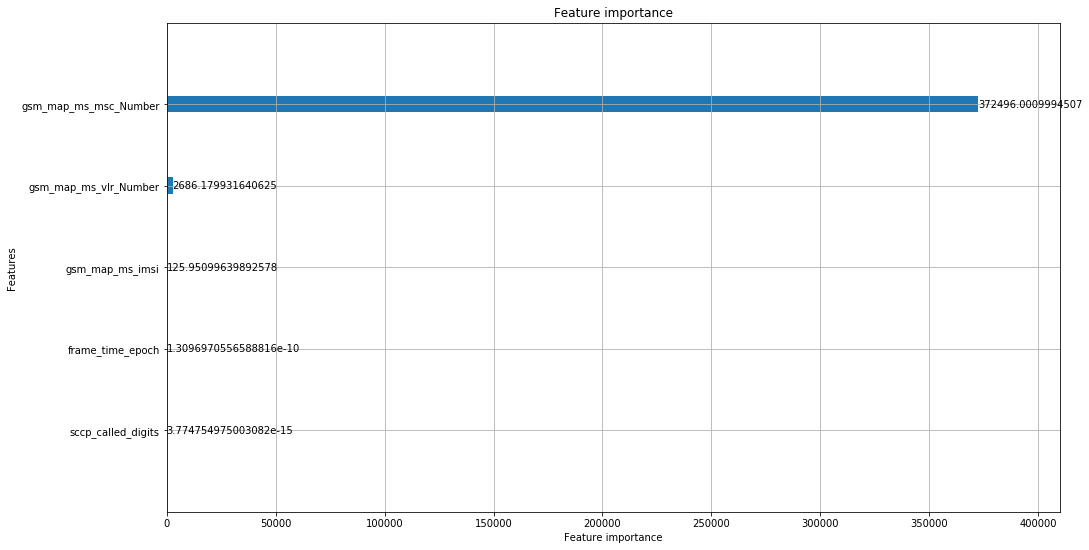

In [28]:
lgb.plot_importance(model, max_num_features=30, importance_type='gain', figsize=(16,9))

In [29]:
with open('model_config_attacks.pkl', 'wb') as fout:
    pickle.dump(model_config, fout, protocol=pickle.HIGHEST_PROTOCOL)

In [30]:
graph = lgb.create_tree_digraph(model, tree_index=0, name='Tree')
graph.render(view=True)

'Tree.gv.pdf'